# Reject Inference Compiled Notebook #

### Packages ###

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, confusion_matrix, roc_auc_score, recall_score

from imblearn.ensemble import BalancedRandomForestClassifier

import RIfunctions as ri

### Variables ###

In [2]:
RANDOM_STATE = 123
CROSS_VALIDATION = 10

## Application Dataset ##

### Pre-processing ###

In [3]:
# Read CSV files into pandas dataframe
application_df = pd.read_csv('input_file_1.csv', sep = ',', index_col=0)

C:\Users\joshy\AppData\Roaming\Python\Python38\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
# Cast the issue_d variable to datetime type

application_df['issue_d'] = pd.to_datetime(application_df['issue_d'])

In [5]:
# Remove instances with a small number of purpose values and align all values

application_df = ri.purposeCleaning(application_df)

<AxesSubplot:>

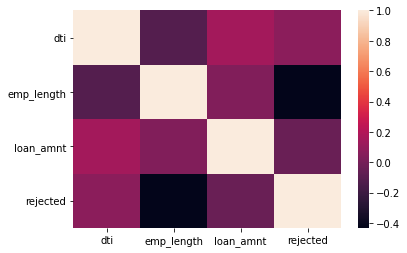

In [6]:
corr = application_df.corr()

sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [7]:
# Get dummies for the purpose variable as it is an object which cannot be interperted

application_df = pd.get_dummies(application_df, columns=['purpose'], drop_first=False)

In [8]:
# Train the model on the full dataset. We are trying to build a pre-existing, trained model, not a new model.

y_train = application_df['rejected']
X_train = application_df.drop(['rejected', 'issue_d'], axis=1)

In [9]:
neg, pos = np.bincount(application_df['rejected'])
total = neg + pos
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Training Set:
    Total: 15384462
    Positive: 14570142 (94.71% of total)



### Logistic Regression Model for Application Dataset ###

In [10]:
# # Optimisation

# pipeline_sgdlogreg = Pipeline([
#     ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
#     ('scaler', StandardScaler(copy=False)),
#     ('model',LogisticRegression(
#         class_weight='balanced',
#         random_state=RANDOM_STATE,
#         n_jobs=-1,
#         warm_start=True
#         )
#     )
# ])

# param_grid_sgdlogreg = {
#     'model__penalty': ['l1', 'l2'],
#     'model__max_iter': [20, 50, 100, 200, 500],                      
#     'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] # Optimisation algorithm
# }

# grid_sgdlogreg = GridSearchCV(
#     estimator=pipeline_sgdlogreg,
#     param_grid=param_grid_sgdlogreg,
#     scoring='roc_auc',
#     pre_dispatch=3,
#     n_jobs=-1,
#     cv=2,
#     verbose=1,
#     return_train_score=False
# )

# grid_sgdlogreg.fit(X_train, y_train)

# print(grid_sgdlogreg.best_estimator_,grid_sgdlogreg.best_params_, grid_sgdlogreg.best_score_)

In [11]:
# Hyperparemeters already optimised

pipeline_sgdlogreg = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', LogisticRegression(
        class_weight='balanced',
        max_iter=1000, 
        tol = 1e-3,
        random_state=1,
        n_jobs=-1,
        warm_start=True,
        penalty='l2'
        )
    )
])

In [12]:
pipeline_sgdlogreg.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                ('scaler', StandardScaler(copy=False)),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, random_state=1, tol=0.001,
                                    warm_start=True))])

In [13]:
# Scores of each application and model performance

y_score = pipeline_sgdlogreg.predict_proba(X_train)[:,1]

y_score_flag = [int(round(i)) for i in y_score]

print(roc_auc_score(y_train, y_score), recall_score(y_train, y_score_flag, pos_label=1), recall_score(y_train, y_score_flag, pos_label=0))

0.8875425525574205 0.8594897016103206 0.7424194419884075


Confusion matrix, without normalization
[[  604567   209753]
 [ 2047255 12522887]]


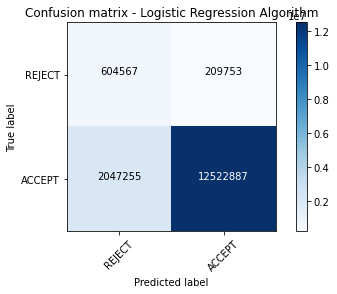

In [14]:
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_train, y_score_flag)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ri.plot_confusion_matrix(cnf_matrix, classes=["REJECT", "ACCEPT"],
                      title='Confusion matrix - Logistic Regression Algorithm')

plt.show()

### Save LR Results ###

In [15]:
# Add score column to the dataframe

application_df['score'] = np.hstack(y_score)

In [16]:
# # Undummy the purpose column (may not be necessary)

# def undummy(d):
#     return d.dot(d.columns)

# application_df = application_df.assign(purpose=application_df.filter(regex='^purpose').pipe(undummy))
# application_df['purpose'] = application_df['purpose'].str.replace("purpose_","")
# application_df = application_df[application_df.columns.drop(list(application_df.filter(regex="purpose_")))]

In [17]:
# Save to CSV file

application_df.to_csv('AR Scores.csv', mode='w+')

## Accepted Loans Dataset ##

### Pre-processing ###

In [18]:
accept_df = pd.read_csv('input_file_2.csv', sep = ',', index_col=0)

In [19]:
accept_df['issue_d'] = pd.to_datetime(accept_df['issue_d'])

In [20]:
'''Exclude the period from the beginning of 2016 onward as it is noticed in time-series plots that this period has
 a significant portion of the expected defaults not reported yet. This would hence be biased.'''

accept_df = accept_df.loc[accept_df['issue_d'] < '2016-1-1']

In [21]:
# Rows with Educational purpose have been dropped in the application dataset

accept_df = accept_df.drop(accept_df[accept_df['purpose'] == 'educational'].index)

In [22]:
all_cols = list(accept_df.columns)
all_cols.remove('charged_off')
all_cols.remove('issue_d')

to_drop_categorical = ['home_ownership', 'verification_status', 'purpose', 'application_type']

for i in to_drop_categorical:

    all_cols.remove(i)

<AxesSubplot:>

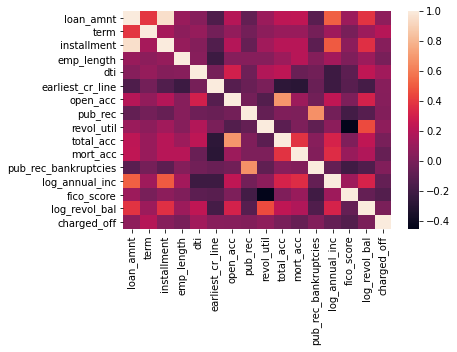

In [23]:
corr = accept_df.corr()

sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [24]:
accept_df_all = pd.get_dummies(accept_df,prefix=["ho","vs","purp","at"], columns=['home_ownership', 'verification_status', 'purpose', 'application_type'], drop_first=False)

In [25]:
# Similar to SimpleImputer  

accept_df_all[all_cols] = accept_df_all[all_cols].fillna(accept_df_all[all_cols].mean())

In [26]:
scaler = StandardScaler(copy=False)

accept_df_all[all_cols] = scaler.fit_transform(accept_df_all[all_cols], accept_df_all['charged_off'])

print(scaler.mean_)

[1.43e+04 4.18e+01 4.33e+02 5.96e+00 1.77e+01 2.00e+03 1.14e+01 1.91e-01
 5.45e+01 2.54e+01 1.78e+00 1.24e-01 4.81e+00 6.97e+02 4.01e+00]


In [27]:
# Splitting dataset into train and test with newer instances 

train_df = accept_df_all.loc[accept_df_all['issue_d'] < accept_df_all['issue_d'].quantile(0.8)]
test_df = accept_df_all.loc[accept_df_all['issue_d'] >= accept_df_all['issue_d'].quantile(0.8)]

In [28]:
train_df = train_df.drop('issue_d', axis=1)
test_df = test_df.drop('issue_d', axis=1)

In [29]:
neg, pos = np.bincount(train_df['charged_off'])
total = neg + pos
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

neg, pos = np.bincount(test_df['charged_off'])
total = neg + pos
print('Testing Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Training Set:
    Total: 499893
    Positive: 91498 (18.30% of total)

Testing Set:
    Total: 146662
    Positive: 39298 (26.79% of total)



In [30]:
y_train = train_df['charged_off']
y_test = test_df['charged_off']

X_train = train_df.drop('charged_off', axis=1)
X_test = test_df.drop('charged_off', axis=1)

### Random Forest Model ###

In [31]:
# # Hyperparameter tuning. Took over 11 hours to run.

# ri.RandomForestTuning(BalancedRandomForestClassifier(), X_train, y_train, filename = "./random_forest.joblib", cv = CROSS_VALIDATION)

In [32]:
model = joblib.load("./random_forest.joblib")
print(model.get_params())

model_2 = BalancedRandomForestClassifier(**model.get_params())
model_2.set_params(max_depth=12)
print(model_2.get_params())
model_2.fit(X_train, y_train)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 100, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 12, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'replacement': False, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}


BalancedRandomForestClassifier(criterion='entropy', max_depth=12,
                               max_features='log2', random_state=42)

In [33]:
cv_scores_train = cross_val_score(estimator= model_2, X=X_train, y=y_train, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_train), std(cv_scores_train)))

cv_scores_test = cross_val_score(estimator= model_2, X=X_test, y=y_test, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Test Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_test), std(cv_scores_test)))

(Training Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: 0.701 (0.014)
(Test Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: 0.706 (0.007)


In [34]:
yhat = model_2.predict(X_test)
print(roc_auc_score(y_test, yhat), recall_score(y_test, yhat, pos_label=1), recall_score(y_test, yhat, pos_label=0))

0.6412572617792924 0.6723751844877602 0.6101393390708245


Confusion matrix, without normalization
[[65507 41857]
 [12875 26423]]


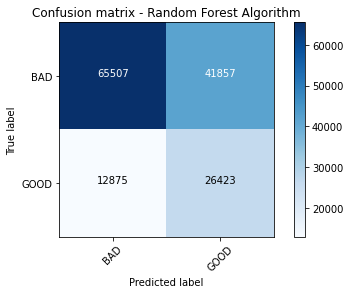

In [35]:
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ri.plot_confusion_matrix(cnf_matrix, classes=["BAD", "GOOD"],
                      title='Confusion matrix - Random Forest Algorithm')

plt.show()

## Matching Characteristics ##

### Pre-processing ###

In [36]:
numerical_cols = ['loan_amnt', 'emp_length', 'dti']
accept_df_reduced = accept_df[['loan_amnt', 'emp_length', 'dti','purpose','charged_off', 'issue_d']]

<AxesSubplot:>

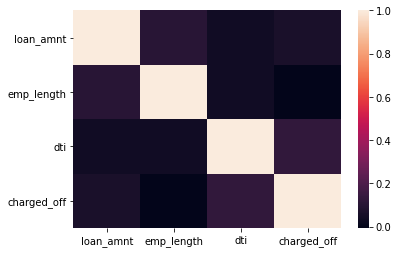

In [37]:
corr = accept_df_reduced.corr()

sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [38]:
accept_df_reduced = pd.get_dummies(accept_df_reduced, prefix=["purp"], columns=['purpose'], drop_first=False)

In [39]:
accept_df_reduced[numerical_cols] = accept_df_reduced[numerical_cols].fillna(accept_df_reduced[numerical_cols].mean())

In [40]:
accept_df_reduced[numerical_cols] = scaler.fit_transform(accept_df_reduced[numerical_cols], accept_df_reduced['charged_off'])

print(scaler.mean_)

[1.43e+04 5.96e+00 1.77e+01]


In [41]:
# Splitting dataset into train and test with newer instances 

train_df_reduced = accept_df_reduced.loc[accept_df_reduced['issue_d'] < accept_df_reduced['issue_d'].quantile(0.8)]
test_df_reduced = accept_df_reduced.loc[accept_df_reduced['issue_d'] >= accept_df_reduced['issue_d'].quantile(0.8)]

In [42]:
train_df_reduced = train_df_reduced.drop('issue_d', axis=1)
test_df_reduced = test_df_reduced.drop('issue_d', axis=1)

In [43]:
neg, pos = np.bincount(train_df_reduced['charged_off'])
total = neg + pos
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

neg, pos = np.bincount(test_df_reduced['charged_off'])
total = neg + pos
print('Testing Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Training Set:
    Total: 499893
    Positive: 91498 (18.30% of total)

Testing Set:
    Total: 146662
    Positive: 39298 (26.79% of total)



In [44]:
y_train_reduced = train_df_reduced['charged_off']
y_test_reduced = test_df_reduced['charged_off']

X_train_reduced = train_df_reduced.drop('charged_off', axis=1)
X_test_reduced = test_df_reduced.drop('charged_off', axis=1)

### Random Forest Model ###

In [45]:
# # Hyperparameter tuning. Took over 11 hours to run.

# ri.RandomForestTuning(BalancedRandomForestClassifier()), X_train_reduced, y_train_reduced, filename = "./random_forest_reduced.joblib", cv = CROSS_VALIDATION)

In [46]:
# model = joblib.load("./random_forest_reduced.joblib")
# print(model.get_params())

model_reduced = BalancedRandomForestClassifier(**model.get_params())
print(model_reduced.get_params())
model_reduced.fit(X_train_reduced, y_train_reduced)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 100, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'replacement': False, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}


BalancedRandomForestClassifier(criterion='entropy', max_depth=100,
                               max_features='log2', random_state=42)

In [47]:
cv_scores_train = cross_val_score(estimator= model_reduced, X=X_train_reduced, y=y_train_reduced, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_train), std(cv_scores_train)))

cv_scores_test = cross_val_score(estimator= model_reduced, X=X_test_reduced, y=y_test_reduced, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Test Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_test), std(cv_scores_test)))

(Training Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: 0.554 (0.007)
(Test Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: 0.565 (0.007)


In [49]:
yhat = model_reduced.predict(X_test_reduced)
print(roc_auc_score(y_test_reduced, yhat), recall_score(y_test_reduced, yhat, pos_label=1), recall_score(y_test_reduced, yhat, pos_label=0))

0.5448009977872361 0.573311618911904 0.5162903766625685


Confusion matrix, without normalization
[[55431 51933]
 [16768 22530]]


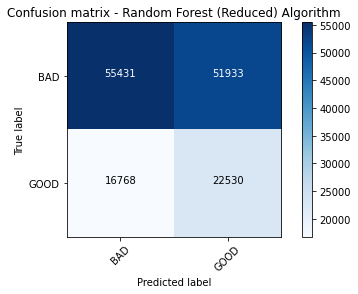

In [50]:
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test_reduced, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ri.plot_confusion_matrix(cnf_matrix, classes=["BAD", "GOOD"],
                      title='Confusion matrix - Random Forest (Reduced) Algorithm')

plt.show()

## Reject Inference Techniques ##

### Simple Assignment ###

In [ ]:
rejects = application_df.loc[application_df["rejected"] ==1]

In [ ]:
ri_df = pd.concat([accept_df, rejects], axis=0, ignore_index=True)
ri_df.loc[ri_df['rejected'] == 1, 'charged_off'] = 1

In [ ]:
# filename = 'Results %s.txt' % (dt_string)


# with open(filename, 'w') as f:
#     f.write("Model Built at ")
#     f.write("%s\n" % dt_string)
#     f.write("%s\n" % "Model Architecture")
#     f.write("%s\n" % model.to_json(indent=4))
#     f.write("%s\n" % "Training AUC")
#     for score in history.history[r'auc_51']:
#         f.write("%s\n" % score)
#     f.write("%s\n" % "Test AUC")
#     f.write("%s\n" % str(accuracy))
#     f.close()